In [1]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline

Visualize data sample:

(76, 76)


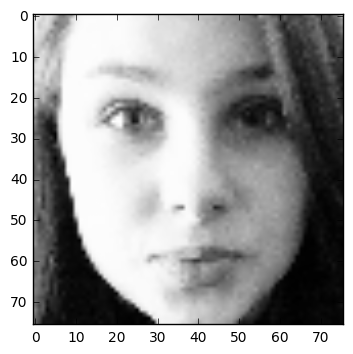

In [2]:
path = "/home/lebedev/Downloads/RUS-FD/Template A/0001_F14.bmp"
image = data.load(path)
print(image.shape)
plt.imshow(image, cmap='Greys_r')

Load input to RAM:

In [3]:
def extractGender(file):
    index = file.find("_")
    letter = file[index + 1] 
    if(letter == "F"): 
        return np.array([1, 0])
    else: 
        return np.array([0, 1])

In [4]:
import os
import glob

folder = "/home/lebedev/Downloads/RUS-FD/Template A"

images = []
labels = []

for file in glob.glob(os.path.join(folder, "*.bmp")):
    images.append(data.load(file))
    labels.append(extractGender(file))

Preprocess data:

In [5]:
class TrainingDataSet(object):
    def __init__(self, images, labels):
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        
        #TODO: is it necessary
        self._epochs_completed = 0
        self._index_in_epoch = 0
    @property
    def images(self):
        return self._images
    
    @property
    def labels(self):
        return self._labels
    
    @property
    def num_examples(self):
        return self._num_examples
    
    @property
    def epochs_completed(self):
        return self._epoch_completed
    
    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        
        if(self._index_in_epoch > self._num_examples):
            self._epochs_completed += 1
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            start = 0
            self._index_in_epoch = batch_size
        end = self._index_in_epoch
        
        return self._images[start:end], self._labels[start:end]

In [6]:
input = np.empty((0, 76, 76))
output = np.empty((0, 2))

for image, label in zip(images, labels):
    input = np.append(input, [image], axis=0)
    output = np.append(output, [label], axis=0)

input = np.multiply(input.astype(np.float32).reshape(input.shape[0], input.shape[1]*input.shape[2]), 1.0/255)

In [7]:
print(input.shape)
print(output.shape)

(4630, 5776)
(4630, 2)


Verify data:

In [8]:
#verify class distribution between data

In [9]:
from sklearn import cross_validation

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(input, output)
training_data = TrainingDataSet(X_train, Y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
import tensorflow as tf

In [11]:
learningRate = 0.01
batchSize = 175
train_epoch = 65

In [12]:
nInput = 5776
nClasses = 2
dropout = 0.75

In [13]:
X = tf.placeholder(tf.float32, [None, nInput])
Y = tf.placeholder(tf.float32, [None, nClasses])
keep_prob = tf.placeholder(tf.float32)

In [14]:
weights = {
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 64])),
    'fc' : tf.Variable(tf.random_normal([38*38*64, 2048])),
    'out' : tf.Variable(tf.random_normal([2048, nClasses]))
}

In [15]:
reshapedX = tf.reshape(X, shape=[-1, 76, 76, 1])
conv1 = tf.nn.relu(tf.nn.conv2d(reshapedX, weights['w1'], strides=[1, 1, 1, 1], padding='SAME'))
conv1 = tf.nn.max_pool(conv1 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv1 = tf.nn.dropout(conv1, keep_prob)

dense1 = tf.reshape(conv1, [-1, weights['fc'].get_shape().as_list()[0]]) 

dense1 = tf.nn.relu(tf.matmul(dense1, weights['fc']))
dense1 = tf.nn.dropout(dense1, keep_prob)
pred = tf.matmul(dense1, weights['out'])

In [16]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(cost)

In [17]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [18]:
init = tf.initialize_all_variables()
saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [19]:
display_step = 1

with tf.Session() as sess:
    sess.run(init)
    step = 1
    
    while step < train_epoch:
        batch_xs, batch_ys = training_data.next_batch(batchSize)
        
        sess.run(optimizer, feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: dropout})
        
        if step % display_step == 0:
            acc = sess.run(accuracy, feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 1.})
            loss = sess.run(cost, feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 1.})
            print("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
        step += 1
    
    save_path = saver.save(sess, "model")
    
    print("Optimization Finished!")
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: X_test[:256], 
                                                             Y: Y_test[:256], 
                                                             keep_prob: 1.}))

Iter 1, Minibatch Loss= 497900.187500, Training Accuracy= 0.57143
Iter 2, Minibatch Loss= 318158.437500, Training Accuracy= 0.45714
Iter 3, Minibatch Loss= 55281.691406, Training Accuracy= 0.59429
Iter 4, Minibatch Loss= 63626.320312, Training Accuracy= 0.49714
Iter 5, Minibatch Loss= 83175.390625, Training Accuracy= 0.46857
Iter 6, Minibatch Loss= 67017.468750, Training Accuracy= 0.53143
Iter 7, Minibatch Loss= 56308.285156, Training Accuracy= 0.44571
Iter 8, Minibatch Loss= 30715.693359, Training Accuracy= 0.42857
Iter 9, Minibatch Loss= 1170.748169, Training Accuracy= 0.72571
Iter 10, Minibatch Loss= 15812.034180, Training Accuracy= 0.57714
Iter 11, Minibatch Loss= 30167.929688, Training Accuracy= 0.46286
Iter 12, Minibatch Loss= 28532.068359, Training Accuracy= 0.48000
Iter 13, Minibatch Loss= 21945.107422, Training Accuracy= 0.56000
Iter 14, Minibatch Loss= 17131.023438, Training Accuracy= 0.51429
Iter 15, Minibatch Loss= 9288.859375, Training Accuracy= 0.50857
Iter 16, Minibatch 

In [21]:
F = 0
M = 0
for label in Y_test:
    if label[0] == 1:
        F += 1
    else:
        M += 1
print(F, M)

553 605
